# 股價分析預測Sample
### 在本教程中，我們將嘗試預測APPL股票價格中存在的向上和向下趨勢，即我們對預測所採取的方向更感興趣，而不是他們的價值與實際股票價格的接近程度。

### 我們不會使用時間序列預測，而是使用長期短期記憶（LSTM）進行預測。 它比ARIMA模型表現更好。 我們將設計具有高維度的堆疊LSTM。

### 我們將使用6年的APPL股票價格培訓我們的LSTM模型，從2009年的上一個財政日期到2016年的最後一個財務日期。根據我們的模型所捕獲的相關性，我們將嘗試預測第一財務的開放股票價格 2017年的一天到2018年8月的最後一個財政日。再次，我們不會預測實際價格，而是試圖預測股價的上行和下行趨勢。

## Importing the libraries.

In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

import math
from sklearn.metrics import mean_squared_error

## Loading APPL Stock Price train and test dataset

In [20]:
#將trian.csv讀入
train_data = pd.read_csv("train.csv", header=0)

In [21]:
#查看train前五筆資料型態
train_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-12-31,30.447144,30.478571,30.080000,30.104286,20.230061,88102700
1,2010-01-04,30.490000,30.642857,30.340000,30.572857,20.544939,123432400
2,2010-01-05,30.657143,30.798571,30.464285,30.625713,20.580460,150476200
3,2010-01-06,30.625713,30.747143,30.107143,30.138571,20.253105,138040000
4,2010-01-07,30.250000,30.285715,29.864286,30.082857,20.215658,119282800


In [22]:
#將test.csv讀入
test_data = pd.read_csv("test.csv")

In [23]:
#查看test前五筆資料型態
test_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,115.800003,116.330002,114.760002,116.150002,113.013916,28781900
1,2017-01-04,115.849998,116.510002,115.750000,116.019997,112.887413,21118100
2,2017-01-05,115.919998,116.860001,115.809998,116.610001,113.461502,22193600
3,2017-01-06,116.779999,118.160004,116.470001,117.910004,114.726402,31751900
4,2017-01-09,117.949997,119.430000,117.940002,118.989998,115.777237,33561900


## Visualizing train data
pd.datetime.strptime 用法: https://blog.csdn.net/lz_peter/article/details/78075909

In [24]:
#時間轉換
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data_train = pd.read_csv('train.csv', parse_dates=['Date'], index_col='Date',date_parser=dateparse)

C:\Users\kevin\AppData\Local\Temp\ipykernel_29144\3244096761.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')


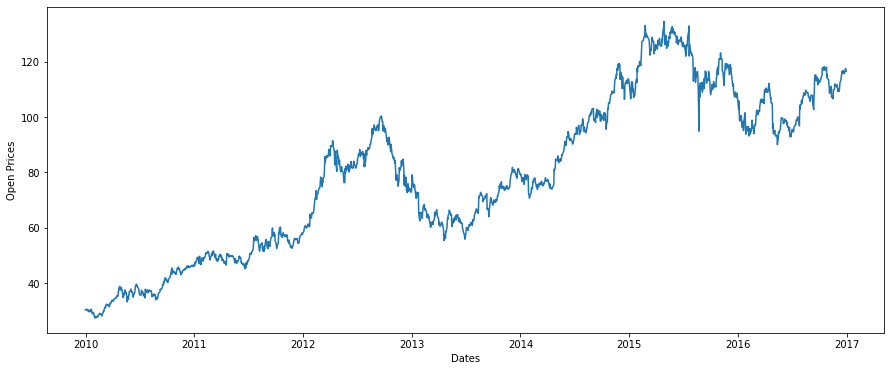

In [25]:
#定義圖數據
ts = data_train['Open'] 
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(ts)

## Visualizing test data Open Price trends with respect to date that will be predicted by our RNN model

In [26]:
data_test = pd.read_csv('test.csv', parse_dates=['Date'], index_col='Date',date_parser=dateparse)

C:\Users\kevin\AppData\Local\Temp\ipykernel_29144\3244096761.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')


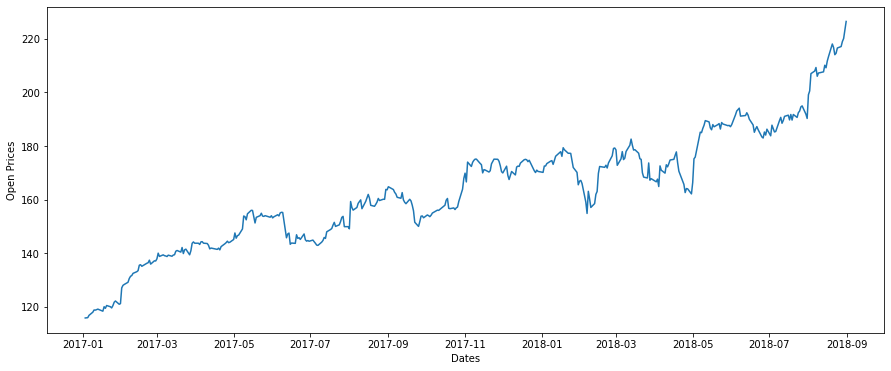

In [27]:
ts = data_test['Open'] 
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(ts)

In [28]:
train_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-12-31,30.447144,30.478571,30.080000,30.104286,20.230061,88102700
1,2010-01-04,30.490000,30.642857,30.340000,30.572857,20.544939,123432400
2,2010-01-05,30.657143,30.798571,30.464285,30.625713,20.580460,150476200
3,2010-01-06,30.625713,30.747143,30.107143,30.138571,20.253105,138040000
4,2010-01-07,30.250000,30.285715,29.864286,30.082857,20.215658,119282800
...,...,...,...,...,...,...,...
1758,2016-12-23,115.589996,116.519997,115.589996,116.519997,113.373917,14181200
1759,2016-12-27,116.519997,117.800003,116.489998,117.260002,114.093948,18296900
1760,2016-12-28,117.519997,118.019997,116.199997,116.760002,113.607445,20905900
1761,2016-12-29,116.449997,117.110001,116.400002,116.730003,113.578247,15039500


In [29]:
train_data.iloc[:, 1:2]

,Open
0,30.447144
1,30.490000
2,30.657143
3,30.625713
4,30.250000
...,...
1758,115.589996
1759,116.519997
1760,117.519997
1761,116.449997


In [30]:
train = train_data.iloc[:, 1:2].values

In [31]:
train_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-12-31,30.447144,30.478571,30.080000,30.104286,20.230061,88102700
1,2010-01-04,30.490000,30.642857,30.340000,30.572857,20.544939,123432400
2,2010-01-05,30.657143,30.798571,30.464285,30.625713,20.580460,150476200
3,2010-01-06,30.625713,30.747143,30.107143,30.138571,20.253105,138040000
4,2010-01-07,30.250000,30.285715,29.864286,30.082857,20.215658,119282800
...,...,...,...,...,...,...,...
1758,2016-12-23,115.589996,116.519997,115.589996,116.519997,113.373917,14181200
1759,2016-12-27,116.519997,117.800003,116.489998,117.260002,114.093948,18296900
1760,2016-12-28,117.519997,118.019997,116.199997,116.760002,113.607445,20905900
1761,2016-12-29,116.449997,117.110001,116.400002,116.730003,113.578247,15039500


## Feature Scaling

In [32]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)

In [34]:
train

array([[ 30.447144],
       [ 30.49    ],
       [ 30.657143],
       ...,
       [117.519997],
       [116.449997],
       [116.650002]])

In [33]:
train_scaled

array([[0.02772252],
       [0.02812313],
       [0.02968552],
       ...,
       [0.84165045],
       [0.83164845],
       [0.83351803]])

In [16]:
X_train

array([[0.02772252, 0.02812313, 0.02968552, ..., 0.05147893, 0.04884823,
        0.05425652],
       [0.02812313, 0.02968552, 0.02939173, ..., 0.04884823, 0.05425652,
        0.05906389],
       [0.02968552, 0.02939173, 0.02587969, ..., 0.05425652, 0.05906389,
        0.05758164],
       ...,
       [0.79668819, 0.79995987, 0.80313811, ..., 0.83071369, 0.82360944,
        0.83230278],
       [0.79995987, 0.80313811, 0.80594237, ..., 0.82360944, 0.83230278,
        0.84165045],
       [0.80313811, 0.80594237, 0.81164445, ..., 0.83230278, 0.84165045,
        0.83164845]])

## Now we will creating a data structure with 60 timesteps and 1 output, i.e.Open Stock Price 

In [15]:
X_train = []
y_train = []
for i in range(60, train.shape[0]):
    X_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

## Reshaping
*  ### Here second argument is (batch_size, time_step ,input_dim)
* ### batch_size is total number of stock price from 2009-12-31 to 2016, i.e. given by X_train.shape[0]
* ### time_step is total number of previous stock price we want to consider while predicting present stock price, i.e given by X_train.shape[1]
* ### third argument is input_dim-in our case it is 1, i.e.Open price, but it can be more than one. It basically includes all those factors/indicators that can affect present stock price 

In [20]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Building the RNN

# LSTM 
LSTM，全稱為長短期記憶網絡（長短期內存網絡），是一種特殊的RNN，能夠學習到長期依賴關係.LSTM由Hochreiter＆Schmidhuber（1997）提出，許多研究者進行了一系列的工作對其改進並使之發揚光大.LSTM在許多問題上效果非常好，現在被廣泛使用。

LSTM在設計上明確地避免了長期依賴的問題。記住長期信息是小菜一碟！所有的循環神經網絡都有著重複的神經網絡模塊形成鏈的形式。在普通的RNN中，重複模塊結構非常簡單，例如只有一個正切層。

![Alt text](https://www.yunaitong.cn/media/14585445702525/14585498578776.jpg)

LSTM也有這種鏈狀結構，不過其重複模塊的結構不同.LSTM的重複模塊中有4個神經網絡層，並且他們之間的交互非常特別。

![Alt text](https://www.yunaitong.cn/media/14585445702525/14585500063294.png)

各圖示代表意思
![Alt text](https://www.yunaitong.cn/media/14585445702525/14585501719114.jpg)

詳細 :https://www.yunaitong.cn/understanding-lstm-networks.html

In [21]:
model = Sequential()

# Adding the first LSTM layer 
# Here return_sequences=True means whether to return the last output in the output sequence, or the full sequence.
# it basically tells us that there is another(or more) LSTM layer ahead in the network.
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# Dropout regularisation for tackling overfitting
model.add(Dropout(0.20))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

model.add(LSTM(units = 50))
model.add(Dropout(0.25))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
# RMSprop is a recommended optimizer as per keras documentation
# check out https://keras.io/optimizers/ for more details
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)


KeyboardInterrupt



## Now making the predictions and visualising the results

In [16]:
# this will be used later while comparing and visualization
real_stock_price = test_data.iloc[:,1:2].values

In [17]:
# combine original train and test data vertically
# as previous Open Prices are not present in test dataset
# e.g. for predicting Open price for first date in test data, we will need stock open prices on 60 previous dates  
combine = pd.concat((train_data['Open'], test_data['Open']), axis = 0)
# our test inputs also contains stock open Prices of last 60 dates (as described above)
test_inputs = combine[len(combine) - len(test_data) - 60:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

In [18]:
test_data.shape

(420, 7)

In [19]:
# same steps as we followed while processing training data
X_test = []
for i in range(60, 480):
    X_test.append(test_inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
# inverse_transform because prediction is done on scaled inputs
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

## Visualising the results

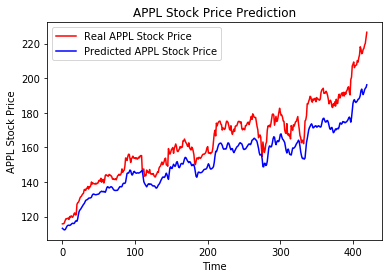

In [19]:
plt.plot(real_stock_price, color = 'red', label = 'Real APPL Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted APPL Stock Price')
plt.title('APPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('APPL Stock Price')
plt.legend()
plt.show()

### 此範例指探討股價是否為上升與下降的趨勢，並不能預測真實股價狀況

In [22]:
import shap

# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(model, X_train[:100])

# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(X_test[:10])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/shap/explainers/deep.py:63: UserWarning: Please keep in mind DeepExplainer is brand new, and we are still developing it and working on characterizing/testing it on large networks. This means you should keep an eye out for odd behavior. Post any issues you run into on github.
  "behavior. Post any issues you run into on github."


In [ ]:
shap.force_plot()